In [3]:
%load_ext autoreload
%autoreload 2  

In [ ]:
import gc
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import os
import pandas as pd
from pathlib import Path
from general_utils import fileio as fileio_utils
import plotting

import torch

from engine import driver
from general_utils import serialization as serialization_utils
from general_utils import tensor as tensor_utils
from general_utils import validation as validation_utils
from analysis.utils import pca

plt.close('all')
gc.collect()

# To get interactive plots, do the following: install ipympl package and
# restart VS code. Then, run either %matplotlib widget or %matplotlib ipympl in 
# the notebook.
%matplotlib widget

In [5]:
def unpad_and_concat_sequences(sequences, lengths):
    """ 
    Takes in two tensors, `sequences` and `lengths`, of shape (N, L, D) and
    (L,), respectively, where N = number of sequences, L = max sequence length, D =
    dimension of sequence data. The sequences are then unpadded and
    concatenated.
    
    Parameters
    ----------
    sequences : 3D tensor of shape (N, L, D).
    lengths : 1D tensor of shape (L,)
    """
    tensor_utils.validate_tensor(sequences, dim=3)
    tensor_utils.validate_tensor(lengths, dim=1)
    
    list_of_sequences = torch.nn.utils.rnn.unpad_sequence(sequences, lengths, batch_first=True)
    return torch.cat(list_of_sequences, dim=0)

def unpad_and_concat_iterable_of_sequences(sequences_iter, lengths_iter):

    list_of_sequences_concat = [
        unpad_and_concat_sequences(sequences, lengths)
        for (sequences, lengths) in zip(sequences_iter, lengths_iter)
    ]
    return torch.cat(list_of_sequences_concat)
    
def get_network_test_output(logs, seed_idx, test_run_id, output_dict='joined', output_key='hidden'):
    """ 
    Based on returned items from engine.eval.process_batch_eval.
    """
    return logs.iloc[seed_idx]['test_runs'][test_run_id]['logger_test'].get_entry(
        level='batch', epoch_idx=0, batch_idx=0
    )[output_dict][output_key]
    


In [64]:
# Set experiment name/parameters.
exp_date = '2025-08-19'
exp_id = '0000'
seed_idx_list = []
test_run_id_list = []

# Build path to experiment.
notebooks_dir = Path(os.getcwd())
top_level_dir = notebooks_dir.parent
exp_dir = f'{top_level_dir}/experiments/{exp_date}/{exp_id}'

# Retrieve all seed indices if none specified.
if len(seed_idx_list) == 0:
    seed_idx_list = [
        int(p.name[-2:]) for p in (Path(exp_dir)).iterdir() if 'seed' in p.name
    ]

# Retrieve logged items from experiment.
logs = []
for seed_idx in seed_idx_list:
    # Build path to seed directory.
    seed_dir = fileio_utils.get_dir(exp_dir) / f'seed{seed_idx:02d}'

    # Set up dict to store all results for current seed.
    seed_dict = {}
    seed_dict['seed_idx'] = seed_idx
    seed_dict['seed_dir'] = str(seed_dir)
    seed_dict['test_runs'] = {}
    
    # Automatically get all test run IDs if none provided.
    if len(test_run_id_list) == 0:
        test_run_id_list = [
            p.name for p in (seed_dir / 'test').iterdir() if p.is_dir()
        ] # Check why this is not in order
        test_run_id_list.sort()
    
    for test_run_id in test_run_id_list:
        # Build path to test directory and record path. 
        test_dir = seed_dir / 'test' / test_run_id
        
        # Dict to contain all results for current test run. 
        seed_dict['test_runs'][test_run_id] = {}
        seed_dict['test_runs'][test_run_id]['test_dir'] = str(test_dir)
        seed_dict['test_runs'][test_run_id]['batch'] = pd.read_json(
            test_dir / 'output' / 'logs' / 'test_batch_log.jsonl', lines=True
        )
        seed_dict['test_runs'][test_run_id]['epoch'] = pd.read_json(
            test_dir / 'output' / 'logs' / 'test_epoch_log.jsonl', lines=True
        )

        # Prepare filepaths/IDs for running testing for trained model to get outputs.
        configs_dir = test_dir / 'configs'
        train_run_id = '_'.join(test_run_id.split('_', -1)[0:4])
        model_filepath = driver.get_model_filepath(exp_dir, seed_idx, train_run_id, model_suffix='_best.pt')

        # Run testing.
        (
            seed_dict['test_runs'][test_run_id]['logger_test'], 
            seed_dict['test_runs'][test_run_id]['model'], 
            seed_dict['test_runs'][test_run_id]['sequences'], 
            _, _, _, _ 
        ) = driver.run_testing_from_filepath(
            model_cfg_filepath=(configs_dir / 'model.json'),
            model_filepath=model_filepath,
            data_test_cfg_filepath=(configs_dir / 'data_test.json'),
            testing_cfg_filepath=(configs_dir / 'testing.json'),
            reproducibility_cfg_filepath=(configs_dir / 'reproducibility.json'),
            seed_idx=seed_idx,
            log_dir=None,
            weights_only=False,
            log_outputs_override=True
        )

    logs.append(seed_dict)

logs = pd.DataFrame(logs)

# Convert tagged dicts back to dataclasses and recover any items 
# encoded as FactoryConfig objects.
logs = serialization_utils.recursive_tagged_dict_to_dataclass(logs)
logs = serialization_utils.recursive_recover(logs)
logs.head()

num_test_runs = len(test_run_id_list)

The `recover` method was called on an object with self.path=torch.utils.data.dataloader.DataLoader, but recovery will be deferred, as self.locked=True.
The `recover` method was called on an object with self.path=torch.device, but recovery will be deferred, as self.locked=True.
The `recover` method was called on an object with self.path=general_utils.ml.logging.Logger, but recovery will be deferred, as self.locked=True.
test cross_entropy_loss for epoch 0: 0.0016060092020779848.
test accuracy for epoch 0: 1.0.
The `recover` method was called on an object with self.path=torch.utils.data.dataloader.DataLoader, but recovery will be deferred, as self.locked=True.
The `recover` method was called on an object with self.path=torch.device, but recovery will be deferred, as self.locked=True.
The `recover` method was called on an object with self.path=general_utils.ml.logging.Logger, but recovery will be deferred, as self.locked=True.
test cross_entropy_loss for epoch 0: 0.0016118226340040565.
te

In [ ]:
# # Set up simpler working dictionary that has just tensors needed.
# working_dict = {
#     seed_idx : {
#         test_run_id : {
#             'hidden': get_network_test_output(seed_idx, test_run_id, output_dict='joined', output_key='hidden')[0],
#             'hidden_lengths': get_network_test_output(seed_idx, test_run_id, output_dict='joined', output_key='hidden')[1],
#             'ground_truth_labels': logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].labels,
#             'generated_labels': get_network_test_output(seed_idx, test_run_id, output_dict='generated', output_key='labels')
#         }
#         for test_run_id in test_run_id_list
#     }
#     for seed_idx in seed_idx_list
# }

In [35]:
test_run_id_list.sort()
print(test_run_id_list)

['md20250819a0000_dr20250819a0000_tr20250819a0000_re20250811a0000_20250819a0000_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0001_tr20250819a0000_re20250811a0000_20250819a0001_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0002_tr20250819a0000_re20250811a0000_20250819a0002_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0003_tr20250819a0000_re20250811a0000_20250819a0003_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0004_tr20250819a0000_re20250811a0000_20250819a0004_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0005_tr20250819a0000_re20250811a0000_20250819a0005_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0006_tr20250819a0000_re20250811a0000_20250819a0006_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0007_tr20250819a0000_re20250811a0000_20250819a0007_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0008_tr20250819a0000_re20250811a0000_20250819a0008_20250811a0000_20250811a0000', 'md20250819a0000_d

In [63]:
logs.iloc[seed_idx]['test_runs'].keys()
# ids = ids.sort()
# # for i_string, string in enumerate(ids):
# #     if not isinstance(string, str):
# #         print(i_string)
# #         print(string)
# type(ids)


dict_keys(['md20250819a0000_dr20250819a0100_tr20250819a0000_re20250811a0000_20250819a0100_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0047_tr20250819a0000_re20250811a0000_20250819a0047_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0101_tr20250819a0000_re20250811a0000_20250819a0101_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0050_tr20250819a0000_re20250811a0000_20250819a0050_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0002_tr20250819a0000_re20250811a0000_20250819a0002_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0006_tr20250819a0000_re20250811a0000_20250819a0006_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0087_tr20250819a0000_re20250811a0000_20250819a0087_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0031_tr20250819a0000_re20250811a0000_20250819a0031_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0075_tr20250819a0000_re20250811a0000_20250819a0075_20250811a0000_20250811a0000', 'md20250

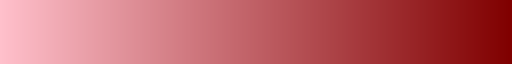

In [8]:
# Define colormaps.
CMAPS = {}
CMAPS[0] = mcolors.LinearSegmentedColormap.from_list(
    'lightskyblue_to_darkblue', 
    [(0, 'lightskyblue'), (1, 'darkblue')]
)
CMAPS[1] = mcolors.LinearSegmentedColormap.from_list(
    'pink_to_maroon', 
    [(0, 'pink'), (1, 'maroon')]
)
CMAPS[1]

### Plot each test run in a separate subplot

['md20250819a0000_dr20250819a0019_tr20250819a0000_re20250811a0000_20250819a0019_20250811a0000_20250811a0000', 'md20250819a0000_dr20250819a0023_tr20250819a0000_re20250811a0000_20250819a0023_20250811a0000_20250811a0000']


/home/jonathan/miniconda3/envs/counting_rnn/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


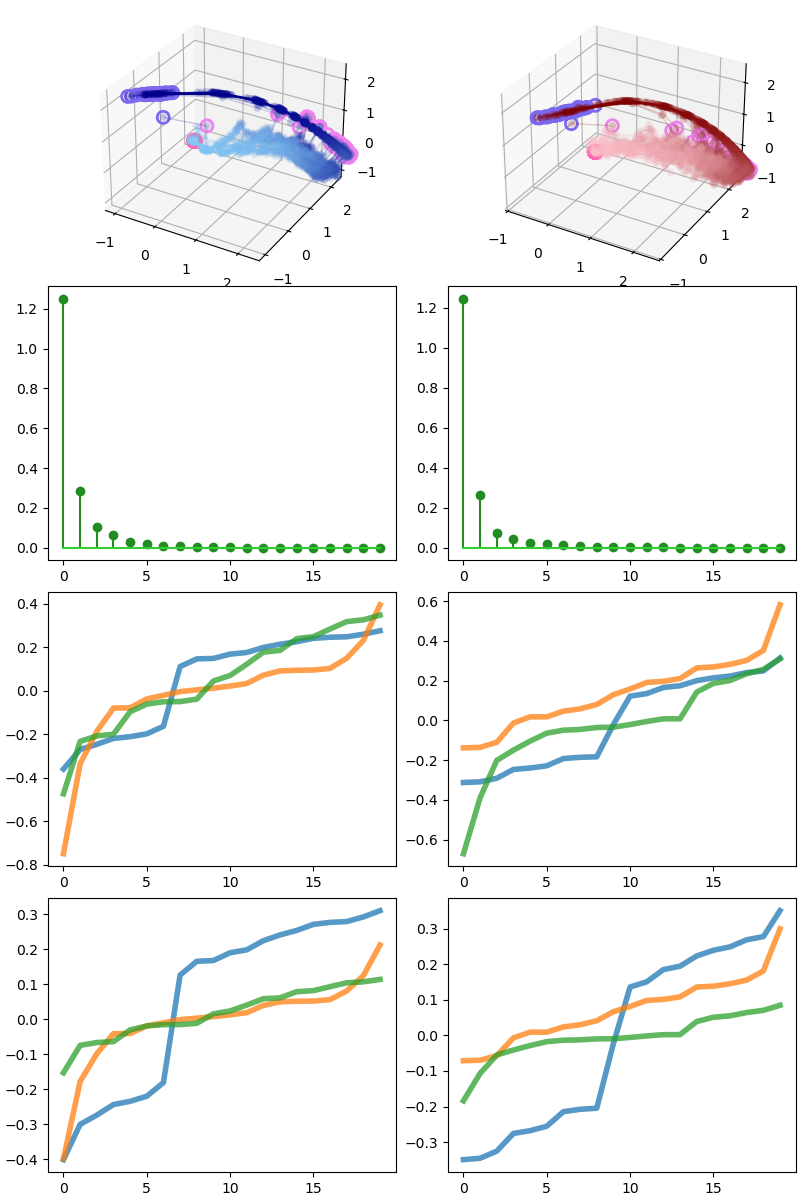

AttributeError: 'NoneType' object has no attribute 'canvas'

AttributeError: 'NoneType' object has no attribute 'canvas'

In [74]:
# Set seed index.
seed_idx = 0

# Number of sequences per test run to plot.
num_seq_to_plot = 50

# Test runs to plot.
test_run_id_to_plot_list = [test_run_id_list[19], test_run_id_list[23]]
num_test_runs_to_plot = len(test_run_id_to_plot_list)
print(test_run_id_to_plot_list)

# Prepare figure axes for all test runs (for one seed).
# dims = plotting.utils.subplot_dims(num_subplots=len(test_run_id_list) * 3, layout='tall')
fig_0, axs_0 = plt.subplots(nrows=4, ncols=num_test_runs_to_plot, subplot_kw={'projection' : '3d'}, squeeze=False, figsize=(8, 3 * 4), constrained_layout=True)

for i_test_run, test_run_id in enumerate(test_run_id_to_plot_list):
    # Get all joined hidden states and joined lengths.
    hidden, hidden_lengths = get_network_test_output(logs, seed_idx, test_run_id, output_dict='joined', output_key='hidden')

    # Project all trajectories onto common basis.
    common_single_test_run = pca(
        unpad_and_concat_sequences(hidden, hidden_lengths),
        num_comps=3 if hidden.shape[-1] >= 3 else hidden.shape[-1],
        corr=False
    )
    hidden_projected = hidden @ common_single_test_run['v']
    
    # Plot hidden state space trajectories and logits.
    seq_ind = torch.arange(num_seq_to_plot)
    batch_idx = 0 # Should be 0 (indexing into pd.Series object) if entire test set passed as a single batch

    for i_seq_idx, seq_idx in enumerate(seq_ind):
        # Get current projected sequence.
        trajectory = hidden_projected[seq_idx, :hidden_lengths[seq_idx], :]
        
        # Hacky, but if 2D, just add some zeros for now so that the 3d plotting still works.
        if trajectory.shape[1] == 2:
            trajectory = torch.cat((trajectory, torch.zeros((trajectory.shape[0], 1))), dim=1)
        
        # Plot hidden state trajectories.
        plotting.plot_trajectory(trajectory, alpha=0.2, ax=axs_0[0, i_test_run], cmap=CMAPS[i_test_run])

        # Get BOS, switch, and EOS token positions.
        labels_test = logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].labels[seq_idx]
        ind = {
            token : torch.where(labels_test == logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].special_tokens[token]['label'])[0]
            for token in ['bos', 'switch', 'eos']
        }
        ind['eos'] -= 1
        colors = ['hotpink', 'violet', 'mediumslateblue']

        # Plot markers for special tokens.
        for i_token, (key, value) in enumerate(ind.items()):
            axs_0[0, i_test_run].scatter(
                trajectory[value, 0], trajectory[value, 1], trajectory[value, 2], 
                color=colors[i_token],
                marker='o',
                facecolors='none',
                s=75,
                linewidths=2,
            )

        # Plot eigenspectrum.
        axs_0[1, i_test_run].remove()
        axs_0[1, i_test_run] = fig_0.add_subplot(4, num_test_runs_to_plot, num_test_runs_to_plot+i_test_run+1)
        axs_0[1, i_test_run].stem(
            common_single_test_run['eigenspectrum'],
            linefmt='forestgreen',
            markerfmt='forestgreen',
            basefmt='limegreen'
        )

        # Plot eigenvector components.
        axs_0[2, i_test_run].remove()
        axs_0[2, i_test_run] = fig_0.add_subplot(4, num_test_runs_to_plot, 2*num_test_runs_to_plot+i_test_run+1)
        for i_pc in range(common_single_test_run['v'].shape[1]):    
            axs_0[2, i_test_run].plot(
                torch.sort(common_single_test_run['v'][:, i_pc])[0],
                alpha=0.75,
                linewidth=4
            )

        # Plot loading components.
        axs_0[3, i_test_run].remove()
        axs_0[3, i_test_run] = fig_0.add_subplot(4, num_test_runs_to_plot, 3*num_test_runs_to_plot+i_test_run+1)
        for i_pc in range(common_single_test_run['loadings'].shape[1]):    
            axs_0[3, i_test_run].plot(
                torch.sort(common_single_test_run['loadings'][:, i_pc])[0],
                alpha=0.75,
                linewidth=4
            )


### Plot all test runs on the same subplot

/tmp/ipykernel_116118/4258655579.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_1, axs_1 = plt.subplots(4, 1, subplot_kw={'projection' : '3d'}, figsize=(8, 18), constrained_layout=True)
/home/jonathan/miniconda3/envs/counting_rnn/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


IndexError: index 23 is out of bounds for dimension 0 with size 21

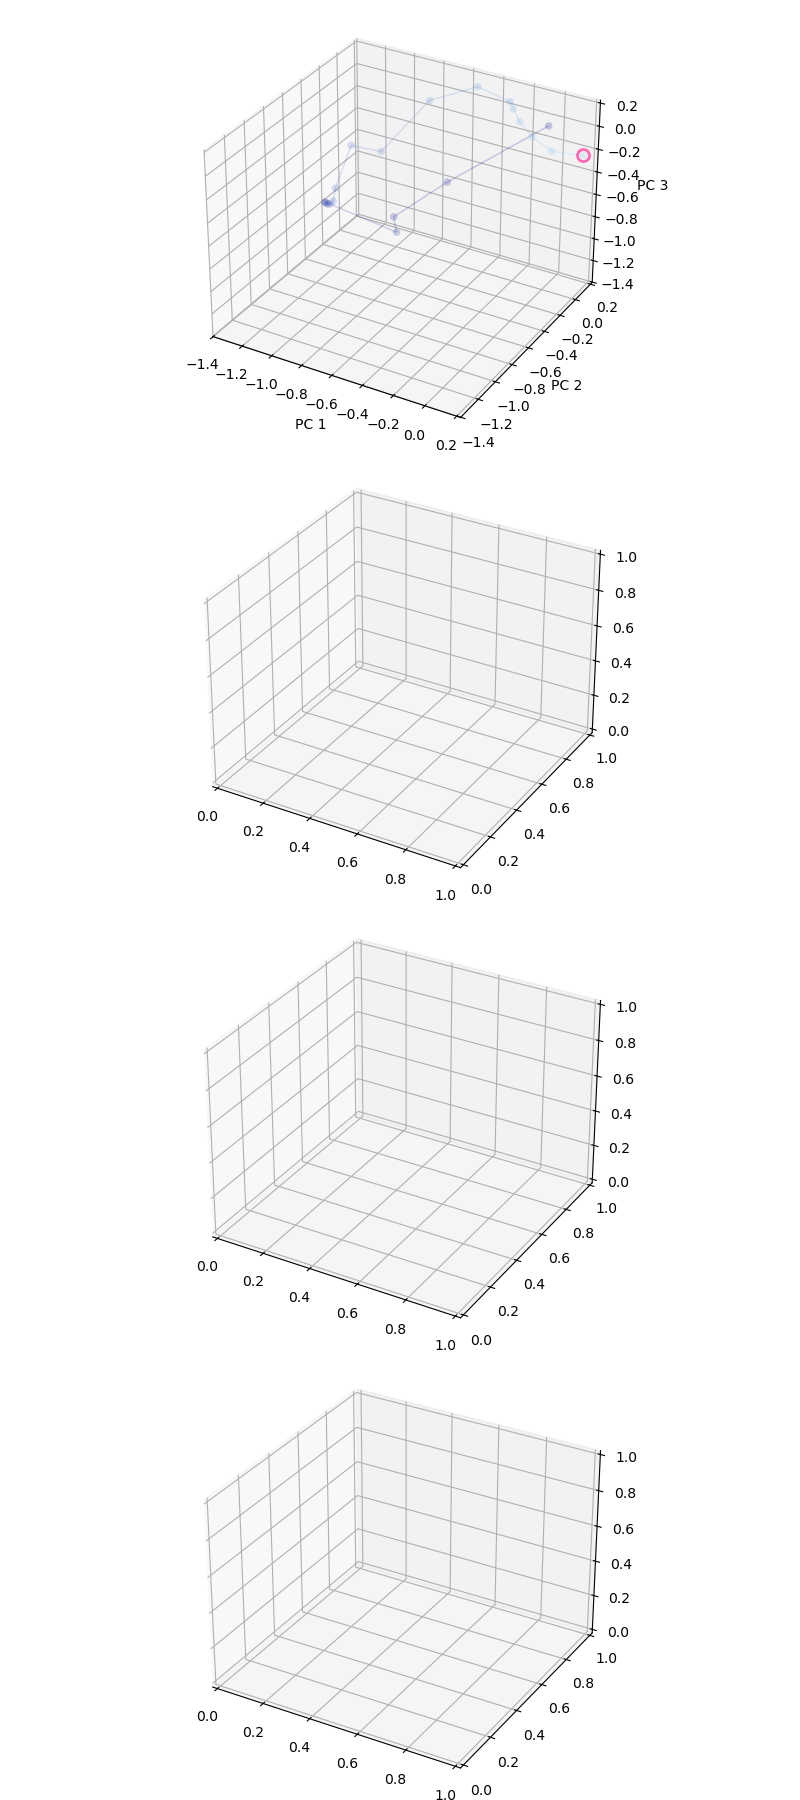

In [66]:
# Use seed index from above cell. Set number of sequences (per test run) to plot independently here.
num_seq_to_plot = 35

# PCs to plot.
pcs_to_plot = [0, 1, 2]

# Prepare single figure axes for all test runs (for one seed).
fig_1, axs_1 = plt.subplots(4, 1, subplot_kw={'projection' : '3d'}, figsize=(8, 18), constrained_layout=True)

# Find basis for all sequences across all test runs. 
hidden_all_test_runs, hidden_lengths_all_test_runs = zip(*(
    get_network_test_output(logs, seed_idx, test_run_id, output_dict='joined', output_key='hidden') 
    for test_run_id in test_run_id_list
))
common_all_test_runs = pca(
    unpad_and_concat_iterable_of_sequences(
        hidden_all_test_runs, hidden_lengths_all_test_runs
    ),
    # num_comps=(
    #     3 if hidden_all_test_runs[0].shape[-1] >= 3 
    #     else hidden_all_test_runs[0].shape[-1]
    # ),
    num_comps=None,
    corr=False
)

for i_test_run, test_run_id in enumerate(test_run_id_to_plot_list):
    # Project trajectories from current test run onto common basis.
    hidden_projected = hidden_all_test_runs[i_test_run] @ common_all_test_runs['v']

    # Plot hidden state space trajectories and logits.
    seq_ind = torch.arange(num_seq_to_plot)

    for i_seq_idx, seq_idx in enumerate(seq_ind):
        # Get hidden states for current sequence and project onto common basis.
        trajectory = hidden_projected[seq_idx, :hidden_lengths_all_test_runs[i_test_run][seq_idx], pcs_to_plot]

        # Hacky, but if 2D, just add some zeros for now so that the 3d plotting still works.
        if trajectory.shape[1] == 2:
            trajectory = torch.cat((trajectory, torch.zeros((trajectory.shape[0], 1))), dim=1)
        
        # Plot hidden state trajectories.
        plotting.plot_trajectory(
            trajectory,
            alpha=0.2,
            ax=axs_1[0],
            cmap=CMAPS[i_test_run]
        )
        axs_1[0].set_xlabel(f'PC {pcs_to_plot[0] + 1}')
        axs_1[0].set_ylabel(f'PC {pcs_to_plot[1] + 1}')
        axs_1[0].set_zlabel(f'PC {pcs_to_plot[2] + 1}')

        # Get BOS, switch, and EOS token positions.
        labels_test = logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].labels[seq_idx]
        ind = {
            token : torch.where(labels_test == logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].special_tokens[token]['label'])[0]
            for token in ['bos', 'switch', 'eos']
        }
        ind['eos'] -= 1
        colors = ['hotpink', 'violet', 'mediumslateblue']

        # Plot markers for special tokens.
        for i_token, (key, value) in enumerate(ind.items()):
            axs_1[0].scatter(
                trajectory[value, 0], trajectory[value, 1], trajectory[value, 2], 
                color=colors[i_token],
                marker='o',
                facecolors='none',
                s=75,
                linewidths=2,
            )

        # Plot eigenspectrum.
        axs_1[1].remove()
        axs_1[1] = fig_1.add_subplot(4, 1, 2)
        axs_1[1].stem(
            common_all_test_runs['eigenspectrum'],
            linefmt='forestgreen',
            markerfmt='forestgreen',
            basefmt='limegreen'
        )

        # Plot eigenvector components.
        axs_1[2].remove()
        axs_1[2] = fig_1.add_subplot(4, 1, 3)
        for i_pc in pcs_to_plot:    
            axs_1[2].plot(
                torch.sort(common_all_test_runs['v'][:, i_pc])[0],
                alpha=0.75,
                linewidth=4
            )

        # Plot loading components.
        axs_1[3].remove()
        axs_1[3] = fig_1.add_subplot(4, 1, 4)
        for i_pc in pcs_to_plot:    
            axs_1[3].plot(
                torch.sort(common_all_test_runs['loadings'][:, i_pc])[0],
                alpha=0.75,
                linewidth=4
            )

        

In [67]:
def construct_confusion_matrix(ground_truth_labels, generated_labels, matrix_support=None):

    # Get target/generated counts for each sequence.
    target_counts = torch.tensor([
        torch.sum(labels >= 4) for labels in ground_truth_labels
    ])
    generated_counts = torch.tensor([
            torch.sum(labels == 0) for labels in generated_labels
        ])

    if matrix_support is None:
        # Integers 0 to N, where N is the max target/generated count.
        ground_truth_support = torch.unique(target_counts)
        generated_support = torch.unique(generated_counts)
        matrix_support = torch.arange(
            max(ground_truth_support.max(), generated_support.max()) + 1 # Plus one since we need counts
        ) 

    # Construct confusion matrix.
    confusion_matrix = torch.full((len(matrix_support), len(matrix_support)), torch.nan)
    for i_elem, elem in enumerate(matrix_support):
        label_ind = target_counts == elem
        confusion_matrix[i_elem, :] = torch.sum(generated_counts[label_ind][:, None] == matrix_support[None, :], dim=0)
        
    return confusion_matrix



tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 38.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 46.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,

/home/jonathan/miniconda3/envs/counting_rnn/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
/home/jonathan/miniconda3/envs/counting_rnn/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
/home/jonathan/miniconda3/envs/counting_rnn/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing

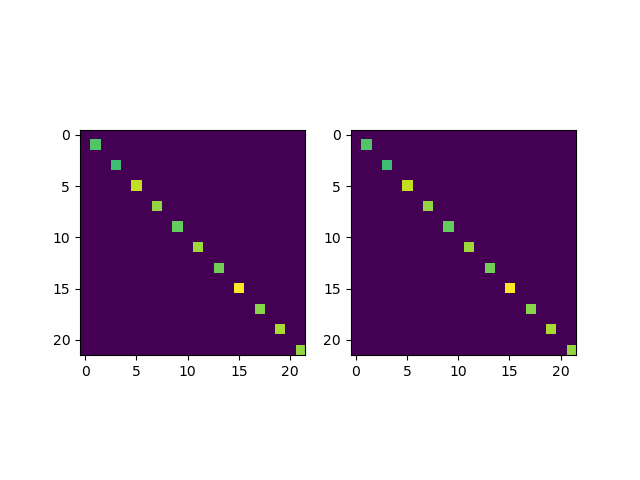

In [68]:
# First get max count across target/generated counts for all test runs to
# specify common support. May as well store labels for easier access during
# plotting step.
labels = {
    test_run_id: {
        'ground_truth': logs.iloc[seed_idx]['test_runs'][test_run_id]['sequences']['test'].labels,
        'generated': get_network_test_output(logs, seed_idx, test_run_id, output_dict='generated', output_key='labels')
    }
    for test_run_id in test_run_id_to_plot_list
}
confusion_matrix_support = torch.arange(
    max([
        max(
            max([torch.sum(labels >= 4) for labels in labels[test_run_id]['ground_truth']]),
            max([torch.sum(labels == 0) for labels in labels[test_run_id]['generated']])
        )
        for test_run_id in test_run_id_to_plot_list
    ])
    + 1
)

# Plot confusion matrices.
fig_2, axs_2 = plt.subplots(1, 2, squeeze=False)
for i_test_run, test_run_id in enumerate(test_run_id_to_plot_list):
    confusion_matrix = construct_confusion_matrix(
        ground_truth_labels=labels[test_run_id]['ground_truth'], 
        generated_labels=labels[test_run_id]['generated'],
        matrix_support=confusion_matrix_support
    )
    i_row, i_col = divmod(i_test_run, num_test_runs_to_plot)
    print(confusion_matrix)
    print(i_test_run)
    axs_2[i_row, i_col].imshow(confusion_matrix)
    print(test_run_id)


In [ ]:
# import re
# import pandas as pd

# def parse_int_id(test_run_id, pattern=r'(\d+)$'):
#     m = re.search(pattern, test_run_id)
#     if not m:
#         raise ValueError(f"Couldn't parse integer id from {test_run_id}")
#     return int(m.group(1))

# def coords_from_id(k: int, nA: int, nB: int):
#     a_idx = k // nB
#     b_idx = k %  nB
#     return a_idx, b_idx

# def make_grid_index(logs, seed_idx: int, nA: int, nB: int, id_regex=r'(\d+)$'):
#     """
#     Returns a MultiIndex DataFrame mapping (a_idx, b_idx) -> test_run_id/test_dir
#     """
#     rows = []
#     for test_run_id, rec in logs.iloc[seed_idx]['test_runs'].items():
#         k = parse_int_id(test_run_id, id_regex)
#         a_idx, b_idx = coords_from_id(k, nA, nB)
#         rows.append({
#             "a_idx": a_idx,
#             "b_idx": b_idx,
#             "test_run_id": test_run_id,
#             "test_dir": rec["test_dir"],
#         })
#     df = pd.DataFrame(rows).set_index(["a_idx", "b_idx"]).sort_index()
#     return df
# import pandas as pd

# def make_grid_index_by_position(logs, seed_idx: int, nA: int, nB: int):
#     """
#     Build (a_idx, b_idx) -> test_run_id/test_dir using the order the runs
#     appear in logs.iloc[seed_idx]['test_runs'] (i.e., directory order).
#     Assumes itertools.product with B varying fastest.
#     """
#     # Preserve insertion order (Python 3.7+ dicts do)
#     ordered_ids = list(logs.iloc[seed_idx]['test_runs'].keys())

#     rows = []
#     for k, test_run_id in enumerate(ordered_ids):
#         a_idx = k // nB            # A slow axis
#         b_idx = k %  nB            # B fast axis
#         rec = logs.iloc[seed_idx]['test_runs'][test_run_id]
#         rows.append({
#             "a_idx": a_idx,
#             "b_idx": b_idx,
#             "test_run_id": test_run_id,
#             "test_dir": rec["test_dir"],
#         })

#     df = pd.DataFrame(rows).set_index(["a_idx", "b_idx"]).sort_index()

#     # Optional sanity checks
#     # print("grid size:", len(df), "expected:", nA*nB)
#     # assert df.index.get_level_values('a_idx').max() <= nA-1
#     # assert df.index.get_level_values('b_idx').max() <= nB-1

#     return df

def make_grid_df(logs, seed_idx: int, num_grid_rows: int, num_grid_cols: int, sort=False):
    """ 
    """
    # Get all test run IDs in dataframe, optionally sort.
    test_run_id_list = list(logs.iloc[seed_idx]['test_runs'].keys())
    if sort:
        test_run_id_list.sort()

    # Create new dataframe with multi-level index.
    rows = []
    for i_test_run, test_run_id in enumerate(test_run_id_list):
        i_row = i_test_run // num_grid_rows
        i_col = i_test_run % num_grid_rows
        rows.append(
            {
                'row_idx': i_row,
                'col_idx': i_col,
                'test_run_id': test_run_id,
                'test_dir': logs.iloc[seed_idx]['test_runs'][test_run_id]['test_dir']
            }
        )
    
    return pd.DataFrame(rows).set_index(['row_idx', 'col_idx'], drop=True, inplace=True).sort_index()




In [70]:
# nA, nB = 18, 6  # your known sizes
# grid_df = make_grid_index(logs, seed_idx=0, nA=nA, nB=nB)
# # Example: get the test_run_id at (a_idx=3, b_idx=9)
# grid_df.loc[(3, 5), "test_run_id"]

nA, nB = 18, 6
grid_df = make_grid_index_by_position(logs, seed_idx=0, nA=nA, nB=nB)

# lookup (a_idx=3, b_idx=5)
grid_df.loc[(3, 5), "test_run_id"]

'md20250819a0000_dr20250819a0023_tr20250819a0000_re20250811a0000_20250819a0023_20250811a0000_20250811a0000'

In [ ]:
# def get_network_test_accuracy(logs, seed_idx, test_run_id, level="epoch", metric="accuracy"):
#     """
#     Retrieve accuracy metric from test logs.
    
#     Parameters
#     ----------
#     logs : DataFrame of experiment logs
#     seed_idx : int, index into logs
#     test_run_id : str, which test run
#     level : "epoch" or "batch"
#     metric : column name in the log DataFrame
#     """
#     df = logs.iloc[seed_idx]['test_runs'][test_run_id][level]
#     if metric not in df.columns:
#         raise KeyError(f"Metric '{metric}' not found in {level} log columns: {df.columns}")
#     return df[metric].iloc[-1]  # last epoch (or batch) entry

# def get_network_test_metric(logs, seed_idx: int, test_run_id: str, level='epoch', epoch_idx=None, batch_idx=None, metric='accuracy'):
#     df = logs.iloc[seed_idx]['test_runs'][test_run_id][level]
    
#     if metric not in df.columns: 
#         raise KeyError(
#             f"metric '{metric}' not in {level} log columns: {df.columns}."
#         )

#     if level == 'epoch':
#         if epoch_idx is None:
#             return df.iloc[-1]
#         else:
#             validation_utils.validate_nonneg_int(epoch_idx)
#             return df[metric].loc[df['epoch_idx'] == epoch_idx]
#     if level == 'batch':
#         if epoch_idx is None and batch_idx is None:
#             return df.iloc[-1]
#         elif not (epoch_idx and batch_idx):
#             raise ValueError(
#                 f"If level='batch', epoch_idx and batch_idx must either both be None, or neither may be None."
#             )
#         return df[metric].loc[df['epoch_idx'] == epoch_idx and df['batch_idx'] == 'batch_idx']

# A test logger object is returned from testing. Could use its built in retreival functionality to easily access logged values from any given epoch or batch.


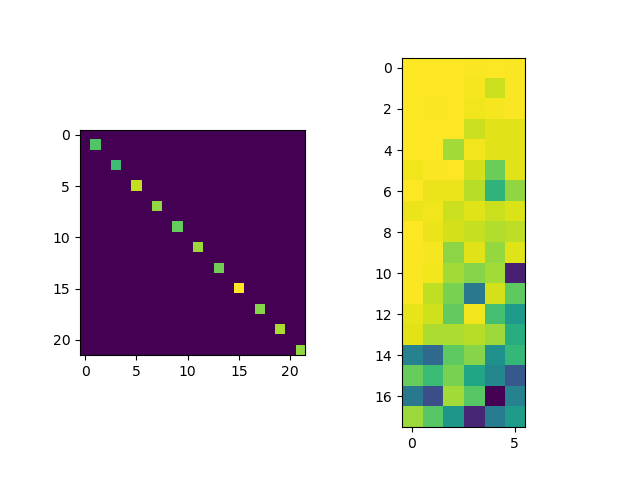

[[1.    1.    1.    0.998 1.    0.998]
 [1.    1.    1.    0.996 0.978 0.998]
 [1.    0.998 1.    0.994 0.996 0.998]
 [1.    1.    1.    0.978 0.988 0.988]
 [1.    1.    0.962 0.994 0.988 0.988]
 [0.994 0.998 1.    0.982 0.938 0.988]
 [1.    0.992 0.992 0.97  0.904 0.954]
 [0.992 0.994 0.978 0.986 0.978 0.984]
 [1.    0.992 0.982 0.976 0.968 0.972]
 [0.998 0.996 0.952 0.988 0.956 0.986]
 [0.998 0.994 0.962 0.95  0.962 0.748]
 [0.998 0.974 0.944 0.834 0.982 0.932]
 [0.99  0.98  0.934 0.994 0.918 0.872]
 [0.988 0.966 0.966 0.97  0.96  0.896]
 [0.846 0.818 0.932 0.95  0.862 0.908]
 [0.936 0.912 0.944 0.886 0.852 0.8  ]
 [0.834 0.79  0.962 0.928 0.724 0.846]
 [0.958 0.928 0.87  0.754 0.838 0.876]]


In [72]:
acc = []
for test_run_id in test_run_id_list:
    acc.append(get_network_test_accuracy(logs, seed_idx=0, test_run_id=test_run_id, metric="accuracy"))
    # print(acc)

accuracy = torch.tensor(acc)

accuracy_grid = torch.full((nA, nB), torch.nan)
for i_A in range(nA):
    for i_B in range(nB):
        accuracy_grid[i_A, i_B] = get_network_test_accuracy(logs, seed_idx=0, test_run_id=grid_df.loc[(i_A, i_B), "test_run_id"], metric="accuracy")

accuracy_np = accuracy_grid.numpy()

plt.imshow(accuracy_np)
plt.show()
print(accuracy_np)
